In [1]:
import tensorflow as tf
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import keras_cv
import shutil
import tqdm
from tqdm.auto import tqdm, trange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import torch
plt.style.use("fivethirtyeight")
keras.mixed_precision.set_global_policy("mixed_float16")
keras.config.set_image_data_format("channels_last")

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
!pip install tensorflow-gpu

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [44 lines of output]
      Traceback (most recent call last):
        File "C:\anaconda\Lib\site-packages\setuptools\_vendor\packaging\requirements.py", line 35, in __init__
          parsed = _parse_requirement(requirement_string)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\anaconda\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 64, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\anaconda\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 82, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\anaconda\Lib\site-packages\setuptools\_vend

In [5]:

!pip install --upgrade keras-cv


     ---------------------------------------- 0.0/42.0 kB ? eta -:--:--
     ---------------------------------------- 0.0/42.0 kB ? eta -:--:--
     ------------------ ------------------- 20.5/42.0 kB 330.3 kB/s eta 0:00:01
     -------------------------------------  41.0/42.0 kB 393.8 kB/s eta 0:00:01
     -------------------------------------- 42.0/42.0 kB 341.2 kB/s eta 0:00:00
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 57.6/57.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/613.1 kB ? eta -:--:--
   ------------------------------------- - 593.9/613.1 kB 12.4 MB/s eta 0:00:01
   ---------------------------------------- 613.1/613.1 kB 9.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/950.8 kB ? eta -:--:--
   --------------------------------------- 950.8/950.8 kB 20

  You can safely remove it manually.


In [6]:
df = pd.read_csv("/kaggle/input/100-bird-species/birds.csv")
df.head()

NameError: name 'pd' is not defined

In [5]:
# df[df["data set"] == "test"]["labels"].unique()

In [6]:
print(f"{'keras version =='.upper()} {keras.__version__}")
print(f"{'tensorflow version =='.upper()} {tf.__version__}")

KERAS VERSION == 3.0.5
TENSORFLOW VERSION == 2.15.0


In [8]:
train_path = "/kaggle/input/100-bird-species/train"
test_path = "/kaggle/input/100-bird-species/test"
valid_path = "/kaggle/input/100-bird-species/valid"

EPOCHS = 25
NUM_CLASSES = len(os.listdir(train_path))
IMAGE_SIZE = (180,180)
BATCH_SIZE = 16
PATIENCE = 9
FACTOR = .3
LEARNING_RATE = 0.0001
SEED = 1906

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/kaggle/input/100-bird-species/train'

In [8]:
train_species = []
test_species = []
val_species = []

for train_, test_, val_ in zip(os.listdir(train_path), os.listdir(test_path), os.listdir(valid_path)):
    train_species.append(train_)
    test_species.append(test_)
    val_species.append(val_)
    
train_species = np.array(train_species)
test_species = np.array(test_species)
val_species = np.array(val_species)

print(f"{np.mean(train_species==test_species)}")
print(f"{np.mean(train_species==val_species)}")
print(f"{np.mean(test_species==val_species)}")

1.0
0.6647619047619048
0.6647619047619048


In [1]:
def plot_bird_image(path_1, path_2) -> None:
    os.chdir(path_1)
    img_1 = os.listdir(path_1)[np.random.randint(0, len(os.listdir(path_1)), 1)[0]]
    img_1 = image.imread(img_1)
    os.chdir(path_2)
    img_2 = os.listdir(path_2)[np.random.randint(0, len(os.listdir(path_2)), 1)[0]]
    img_2 = image.imread(img_2)
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (11,8), sharey = True)
    ax[0].imshow(img_1)
    ax[0].set_title(path_1.split("/")[-1])
    ax[0].grid(False)
    ax[0].axis("on")
    ax[1].imshow(img_2)
    ax[1].set_title(path_2.split("/")[-1])
    ax[1].grid(False)
    
plot_bird_image(path_1 = "/kaggle/input/100-bird-species/train/AFRICAN EMERALD CUCKOO", path_2 = "/kaggle/input/100-bird-species/train/ALPINE CHOUGH")

NameError: name 'os' is not defined

In [10]:
import keras
import tensorflow_hub as hub
from keras.models import Sequential,Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.metrics import CategoricalCrossentropy, SparseCategoricalCrossentropy, Accuracy
from keras.optimizers import Adam, AdamW
from keras.utils import image_dataset_from_directory
keras.utils.set_random_seed(SEED)

In [11]:
os.chdir("/kaggle/input/100-bird-species")
shutil.copytree("valid", "/kaggle/working/valid")
os.rename("/kaggle/working/valid/PARAKETT AUKLET", "/kaggle/working/valid/PARAKETT  AUKLET")

In [12]:
valid_path = "/kaggle/working/valid"

In [13]:
keras.config.set_image_data_format("channels_last")
keras.config.image_data_format()

'channels_last'

In [14]:
def create_image_batch(path_:str, img_size:tuple, batch_size:int, shuffle_:bool, class_names_:list, data_format_:list):
    batch_ = image_dataset_from_directory(
        directory = path_,
        labels = "inferred",
        image_size = img_size,
        seed = SEED,
        batch_size = BATCH_SIZE,
        class_names = class_names_,
        color_mode = "rgb",
        shuffle = shuffle_,
        data_format = data_format_)
    return batch_


train_batch = create_image_batch(path_ = train_path, img_size = IMAGE_SIZE, batch_size = BATCH_SIZE, shuffle_ = True, class_names_ = sorted(os.listdir(train_path)), data_format_ = "channels_last")
valid_batch = create_image_batch(path_ = valid_path, img_size = IMAGE_SIZE, batch_size = BATCH_SIZE, shuffle_ = True, class_names_ = sorted(os.listdir(valid_path)), data_format_ = "channels_last")
test_batch = create_image_batch(path_ = test_path, img_size = IMAGE_SIZE, batch_size = int(BATCH_SIZE/BATCH_SIZE), shuffle_ = False, class_names_ = sorted(os.listdir(test_path)), data_format_ = "channels_last")

Found 84635 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.


In [15]:
class_names = train_batch.class_names
class_names[0:5]

['ABBOTTS BABBLER',
 'ABBOTTS BOOBY',
 'ABYSSINIAN GROUND HORNBILL',
 'AFRICAN CROWNED CRANE',
 'AFRICAN EMERALD CUCKOO']

In [16]:
class_dict = {}
for num, class_name in enumerate(class_names):
    class_dict[num + 1] = class_name

In [17]:
train_species = []
test_species = []
val_species = []

for train_, test_, val_ in zip(train_batch.class_names, valid_batch.class_names, test_batch.class_names):
    train_species.append(train_)
    test_species.append(test_)
    val_species.append(val_)
    
train_species = np.array(train_species)
test_species = np.array(test_species)
val_species = np.array(val_species)

print(f"{np.mean(train_species==test_species)}")
print(f"{np.mean(train_species==val_species)}")
print(f"{np.mean(test_species==val_species)}")

1.0
1.0
1.0


In [18]:
train_batch.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=5290>

In [19]:
def scale_image(img, lbl):
    return img/255.0, lbl

train_batch = train_batch.map(scale_image)
valid_batch = valid_batch.map(scale_image)
test_batch = test_batch.map(scale_image)

In [20]:
pd.Series([1,23,45,22,11]).map(class_dict).values

array(['ABBOTTS BABBLER', 'AMERICAN REDSTART', 'AUSTRAL CANASTERO',
       'AMERICAN PIPIT', 'ALBERTS TOWHEE'], dtype=object)

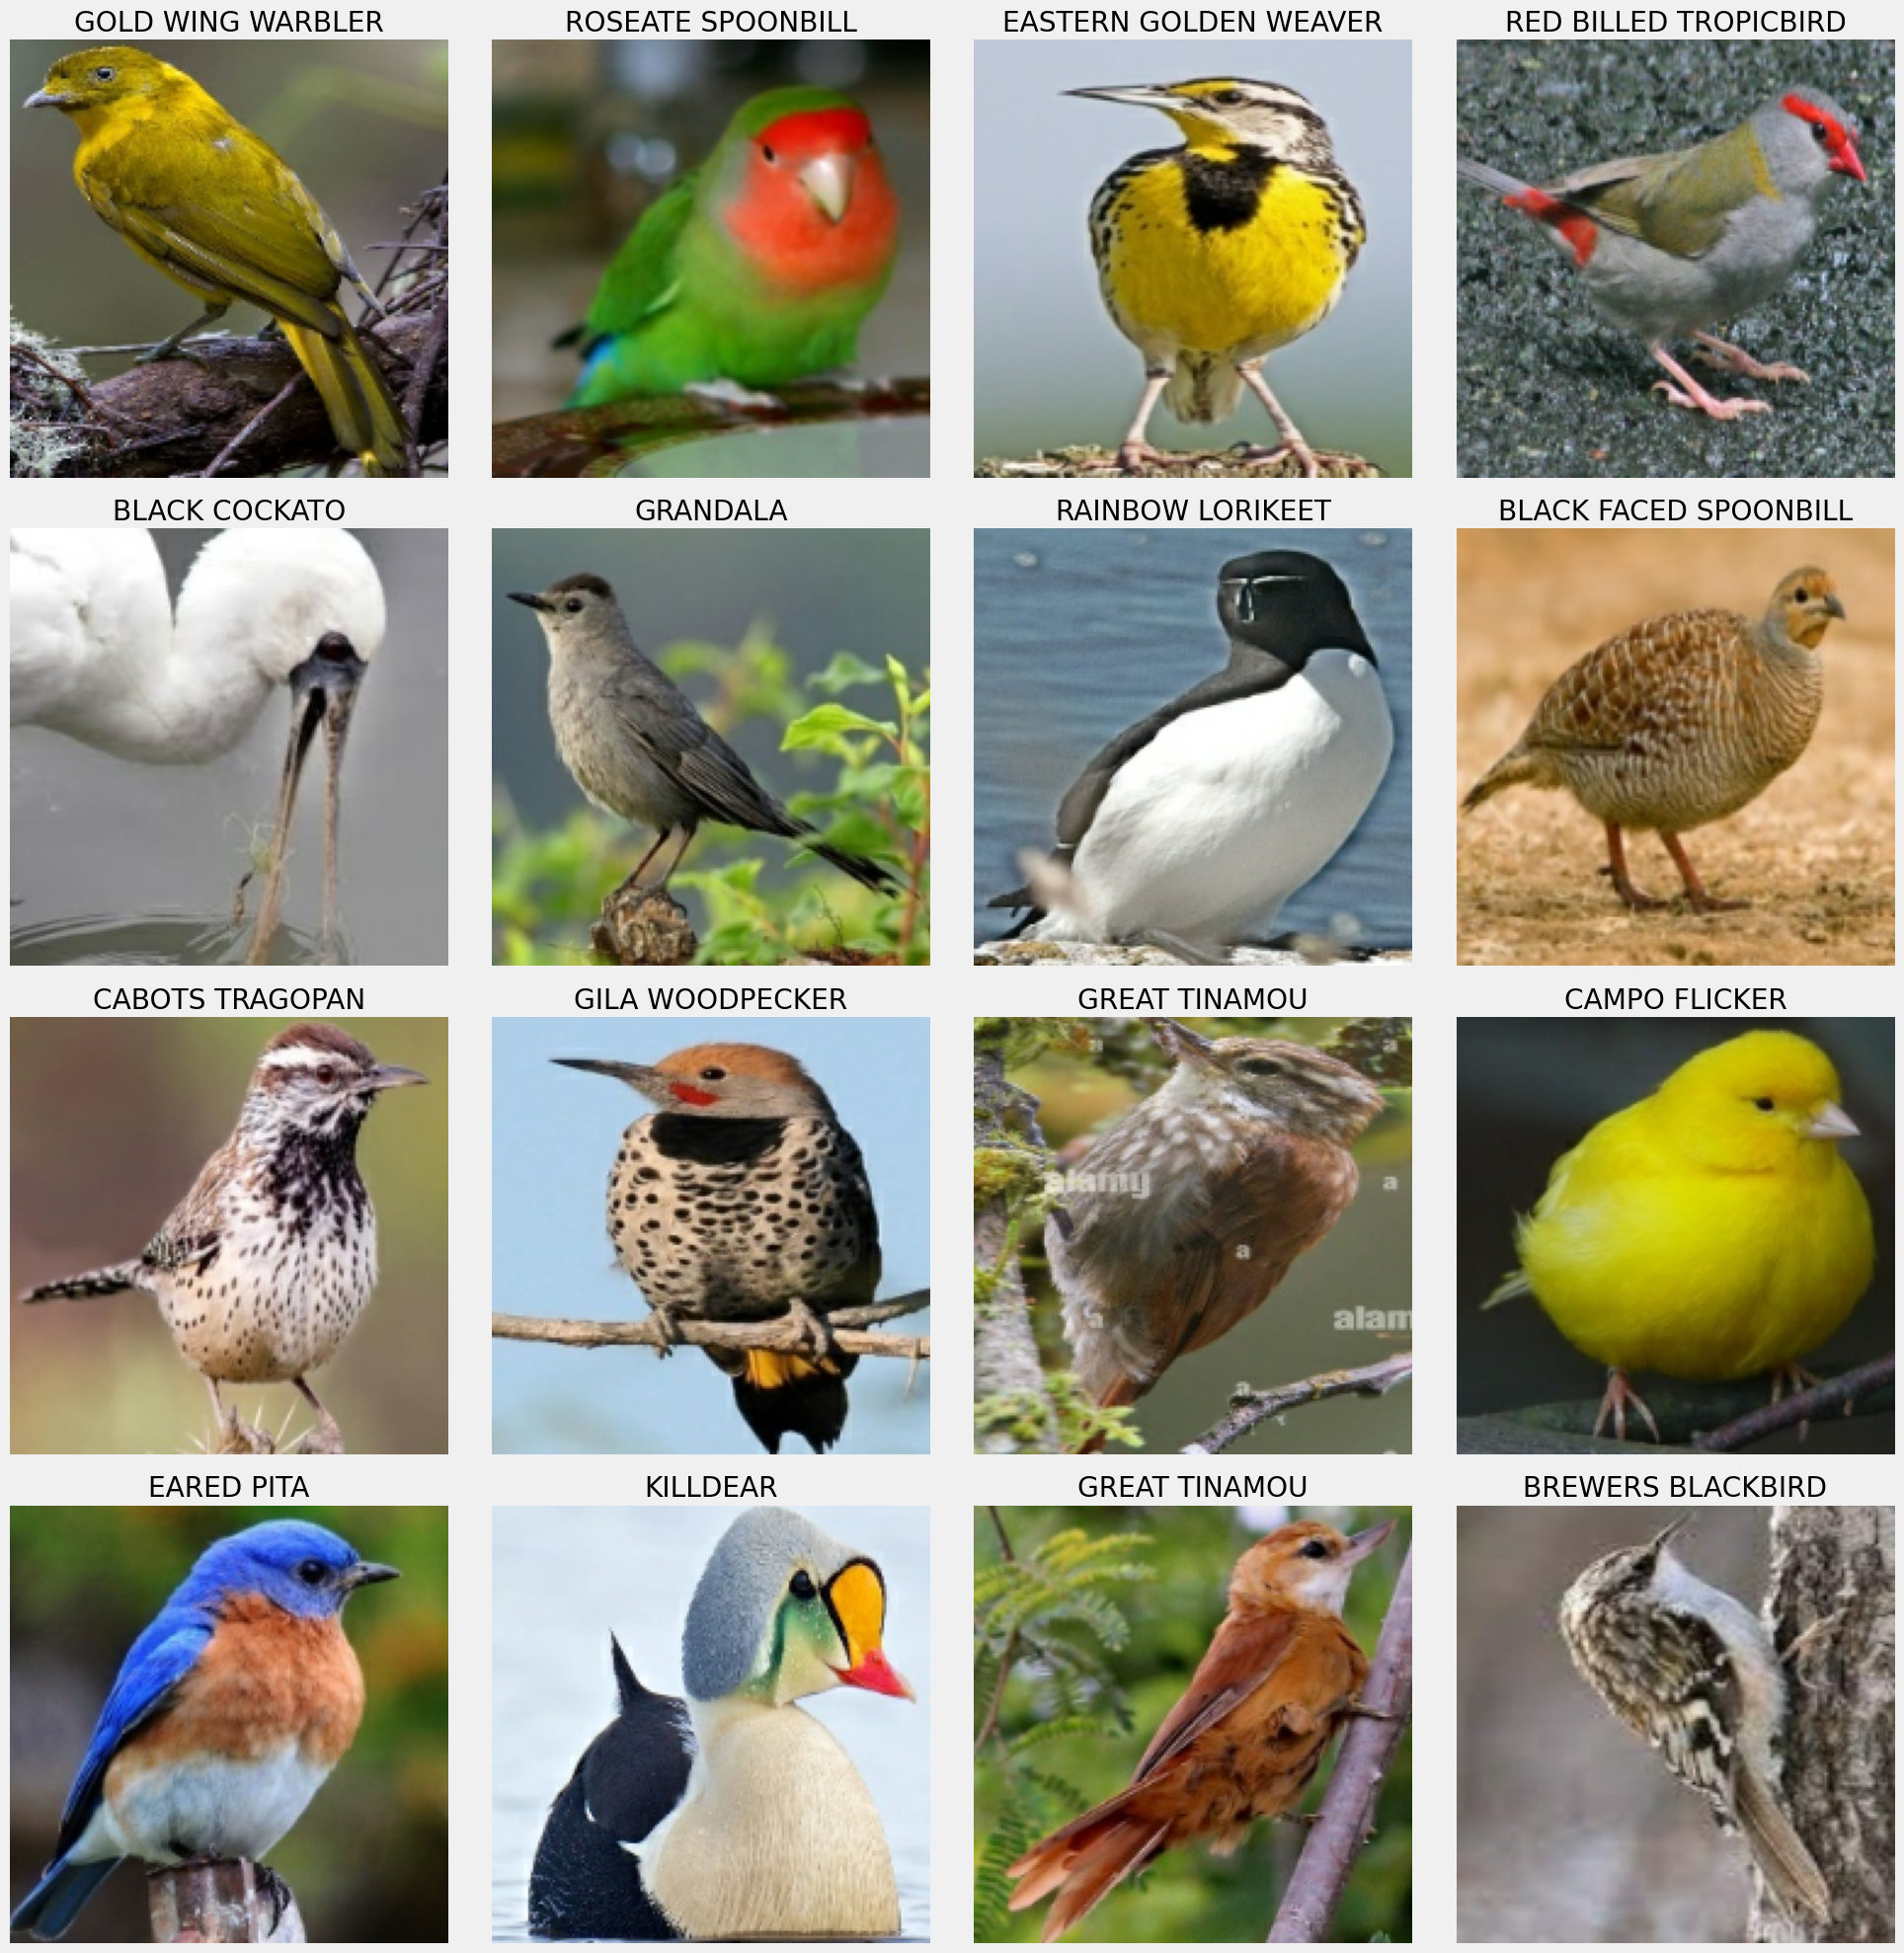

In [21]:
def plot_images(batch_, label_map:dict):
    images_ = []
    labels_ = []
    
    for image, label in batch_.unbatch():
        images_.append(image)
        labels_.append(label)
        
    images_ = np.array(images_)
    labels_ = np.array(labels_)
    labels_ = pd.Series(labels_).map(label_map).values
    labels_ = [i for i in labels_]
    labels = np.array(labels_)
    
    fig, ax = plt.subplots(nrows = 4,ncols = 4, figsize = (20, 20))
    ax = ax.flatten()
    for img, lbl, ax_ in zip(images_[:16], labels[:16], ax):
        ax_.imshow(img)
        ax_.set_title(lbl)
        ax_.axis("off")
    plt.tight_layout()
    
plot_images(valid_batch, label_map = class_dict)

In [22]:
def augment_images(img, lbl):
    image = tf.image.random_flip_left_right(img)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.5, 2.0)
    image = tf.image.random_saturation(image, 0.75, 1.25)
    image = tf.image.random_hue(image, 0.1)
    return image, lbl

train_batch = train_batch.map(augment_images, tf.data.experimental.AUTOTUNE)
train_batch = train_batch.prefetch(tf.data.experimental.AUTOTUNE)
valid_batch = valid_batch.prefetch(tf.data.experimental.AUTOTUNE)

In [23]:
# plot_images(train_batch, label_map = class_dict)

In [24]:
def create_model():
    backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(
    "efficientnetv2_b0_imagenet",
    load_weights=True,
    input_shape = (180,180,3),
    activation = "relu")

    model = keras_cv.models.ImageClassifier(
        num_classes = NUM_CLASSES,
        pooling = "max",
        activation = "softmax",
        backbone = backbone)

    opt_ = AdamW(learning_rate = 0.0001)
    model.compile(optimizer = opt_,
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["accuracy"])
    return model

model = create_model()

Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b0_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b0_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/efficientnetv2/keras/efficientnetv2_b0_imagenet/2' to your Kaggle notebook...


In [25]:
model.summary()

Model: "image_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficient_net_v2b0_backbone     │ (None, 6, 6, 1280)     │     5,919,312 │
│ (EfficientNetV2Backbone)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool (GlobalMaxPooling2D)   │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 525)            │       672,525 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,591,837 (25.15 MB)

 Trainable params: 6,531,229 (24.91 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [26]:
def early_stop():
        stop = EarlyStopping(
          monitor = 'val_accuracy',
          mode = 'max',
          verbose = 1,
          patience = PATIENCE
        )
        return stop
    
    
def reduce_lr():
    reduce_lr_ = ReduceLROnPlateau(
        monitor = 'val_loss',
        mode = 'min',
        verbose = 1,
        factor = .3,
        patience = PATIENCE
    )
    return reduce_lr_

def board_():
    board__ = TensorBoard(
        log_dir = "/kaggle/working/logs",
        histogram_freq = 1,
        profile_batch = 2,
        update_freq = True)
    return board__

In [27]:
model.fit(train_batch,
          validation_data = valid_batch,
          epochs = EPOCHS,
          callbacks = [early_stop(), reduce_lr(), board_()],
          verbose = 1)

Epoch 1/25


I0000 00:00:1709244535.775692      92 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5290/5290 ━━━━━━━━━━━━━━━━━━━━ 549s 77ms/step - accuracy: 0.0891 - loss: 5.8114 - val_accuracy: 0.7962 - val_loss: 0.7877 - learning_rate: 1.0000e-04
Epoch 2/25
5290/5290 ━━━━━━━━━━━━━━━━━━━━ 301s 57ms/step - accuracy: 0.6982 - loss: 1.2207 - val_accuracy: 0.9029 - val_loss: 0.3534 - learning_rate: 1.0000e-04
Epoch 3/25
5290/5290 ━━━━━━━━━━━━━━━━━━━━ 324s 57ms/step - accuracy: 0.8239 - loss: 0.6775 - val_accuracy: 0.9280 - val_loss: 0.2578 - learning_rate: 1.0000e-04
Epoch 4/25
5290/5290 ━━━━━━━━━━━━━━━━━━━━ 296s 56ms/step - accuracy: 0.8754 - loss: 0.4642 - val_accuracy: 0.9402 - val_loss: 0.2217 - learning_rate: 1.0000e-04
Epoch 5/25
5290/5290 ━━━━━━━━━━━━━━━━━━━━ 296s 56ms/step - accuracy: 0.9041 - loss: 0.3491 - val_accuracy: 0.9482 - val_loss: 0.1902 - learning_rate: 1.0000e-04
Epoch 6/25
5290/5290 ━━━━━━━━━━━━━━━━━━━━ 295s 56ms/step - accuracy: 0.9256 - loss: 0.2635 - val_accuracy: 0.9455 - val_loss: 0.1882 - learning_rate: 1.0000e-04
Epoch 7/25
5290/5290 ━━━━━━━━━━━━━━━━━━━━ 294

In [28]:
model_history = pd.DataFrame(data = model.history.history)
model_history.head(7)

accuracy      loss  val_accuracy  val_loss  learning_rate
0  0.272748  3.994818      0.796191  0.787740         0.0001
1  0.740982  1.029650      0.902857  0.353440         0.0001
2  0.841177  0.606337      0.928000  0.257776         0.0001
3  0.886501  0.423808      0.940190  0.221745         0.0001
4  0.913251  0.317693      0.948190  0.190183         0.0001
5  0.931069  0.243628      0.945524  0.188174         0.0001
6  0.945673  0.192554      0.951619  0.175886         0.0001

Text(0.5, 1.0, 'Loss vs Val Loss')

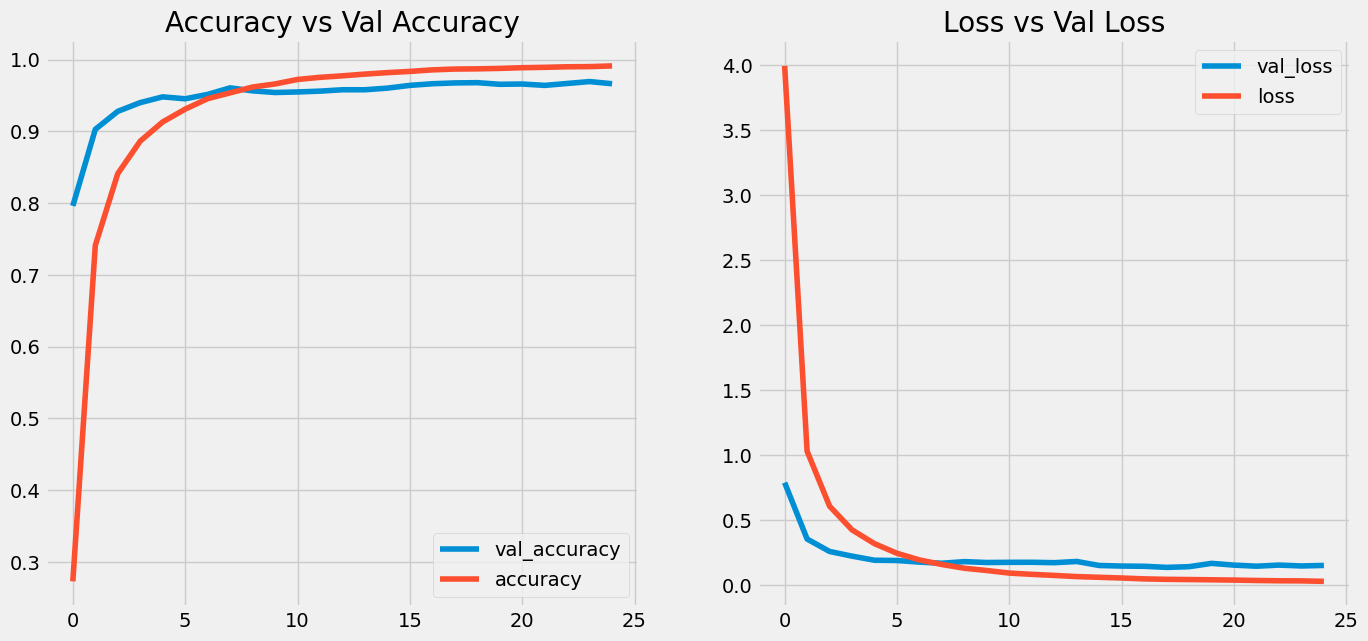

In [29]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 7), sharey = False)
model_history[["val_accuracy", "accuracy"]].plot(ax = ax[0])
model_history[["val_loss", "loss"]].plot(ax = ax[1])
ax[0].set_title("Accuracy vs Val Accuracy")
ax[1].set_title("Loss vs Val Loss")

In [30]:
true_labels = []
for images_, labels_ in test_batch.unbatch():
    true_labels.append(labels_)
    
preds = model.predict(test_batch, verbose = 1)
preds = np.argmax(preds, axis = 1)

true_labels = np.array(true_labels)
preds = np.array(preds)

165/165 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step


In [31]:
print(f"accuracy;; {np.mean(true_labels == preds)}")

accuracy;; 0.9828571428571429


In [32]:
model.save("/kaggle/working/bird_species_.keras")